## Plots with map and spice trend + linear regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from cartopy import crs, feature
from cartopy.feature import NaturalEarthFeature

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

## Loading Data

In [2]:
obs = pd.read_csv(IOPATH)
distline = pd.read_csv("/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/distances.csv")

In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

## Figures

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

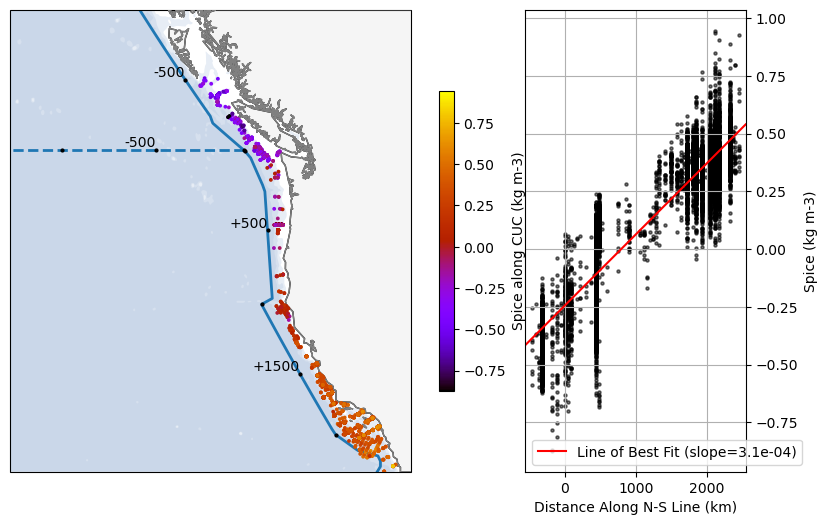

In [5]:
ylim = [30,55]
xlim = [-145,-115]
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.01)  # Adjust width ratio if needed

# Left panel: Map projection
ax0 = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
# Right panel: Standard axes
ax1 = fig.add_subplot(gs[1])

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# plot NS and EW legs
ax0.plot(distline['lonNS'], distline['latNS'], '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(distline['lonEW'], distline['latEW'], '--', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# place tick-marks every ±1000 km —

ticks = [-1000, -500, 0, 500,1000, 1500,2000]
for t in ticks:
    # Draw tick on NS leg if in range
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[1::2]:
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)

    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)


sc = ax0.scatter(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_cuc['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, ax=ax0, orientation='vertical', label='Spice along CUC (kg m-3)', shrink=0.65, aspect=20)


# distline.distNS_out, distline.distEW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])
m, b = np.polyfit(obs_cuc['NSdist'], obs_cuc['spice'], 1)
xfit = np.arange(min(obs_cuc['NSdist'])-100, max(obs_cuc['NSdist'])+100)
yfit = m*xfit + b

ax1.scatter(obs_cuc['NSdist'], obs_cuc['spice'], s=5, alpha=0.55, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(obs_cuc['NSdist'])-100, max(obs_cuc['NSdist'])+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend()
plt.tight_layout()

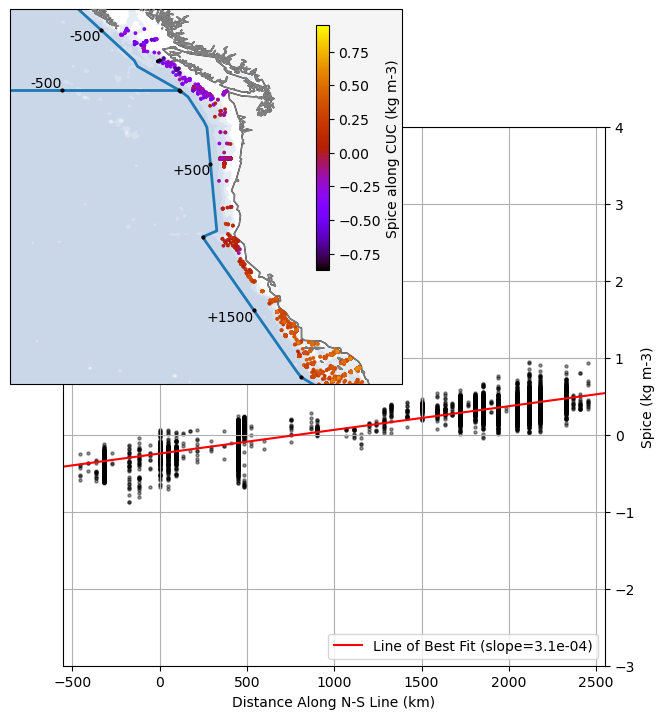

In [6]:
# Main axis
ylim = [32,53]
xlim = [-137,-115]

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 1, 1)

# Inset Cartopy axis as overlay (coordinates in figure fraction)
left, bottom, width, height = 0.05, 0.43, 0.7, 0.7  # Adjust as needed
ax0 = fig.add_axes([left, bottom, width, height], projection=crs.PlateCarree())

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# — 3) plot both legs —
ax0.plot(distline.lonNS, distline.latNS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(distline.lonEW, distline.latEW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-500, 2000 + 1, 500)
for t in ticks:
    # Draw tick on NS leg if in range
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='top', ha='right', fontsize=10, zorder=6)

    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)

sc = ax0.scatter(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_cuc['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, orientation='vertical', label='Spice along CUC (kg m-3)', shrink=0.5, aspect=20, anchor=(-1.8,0.7))


ax1.scatter(obs_cuc.NSdist, obs_cuc['spice'], s=5, alpha=0.4, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(obs_cuc.NSdist)-100, max(obs_cuc.NSdist)+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.set_ylim([-3, 4])
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend(loc='lower right')



## California Current

In [7]:
# make the distance a mixture of the EW and NS line

# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

In [8]:
# drop rows where the distance is nan (161)
obs_cc = obs_cc[~np.isnan(obs_cc.dist)]

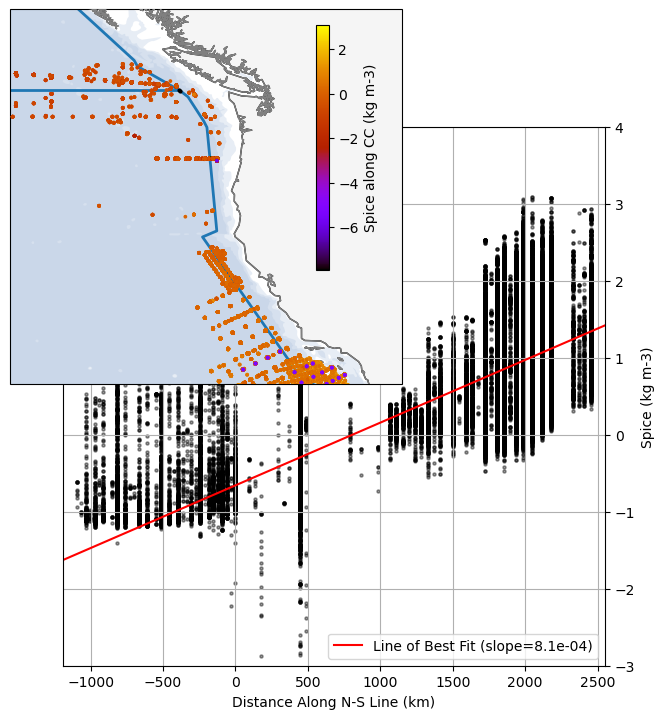

In [9]:
# Main axis
ylim = [32,53]
xlim = [-137,-115]

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 1, 1)

# Inset Cartopy axis as overlay (coordinates in figure fraction)
left, bottom, width, height = 0.05, 0.43, 0.7, 0.7  # Adjust as needed
ax0 = fig.add_axes([left, bottom, width, height], projection=crs.PlateCarree())

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# — 3) plot both legs —
ax0.plot(distline.lonNS, distline.latNS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(distline.lonEW, distline.latEW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-500e3, 2000e3 + 1, 500e3)
for t in ticks:
    # Draw tick on NS leg if in range
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='top', ha='right', fontsize=10, zorder=6)

    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)

# distline.distNS_out, distline.distEW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])
m, b = np.polyfit(obs_cc['dist'], obs_cc['spice'], 1)
xfit = np.arange(min(obs_cc['dist'])-100, max(obs_cc['dist'])+100)
yfit = m*xfit + b

sc = ax0.scatter(obs_cc['longitude (degrees_east)'], obs_cc['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_cc['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, orientation='vertical', label='Spice along CC (kg m-3)', shrink=0.5, aspect=20, anchor=(-1.8,0.7))

ax1.scatter(obs_cc.dist, obs_cc['spice'], s=5, alpha=0.4, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(obs_cc.dist)-100, max(obs_cc.dist)+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.set_ylim([-3, 4])
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend(loc='lower right')

# Shelf Current

In [18]:
# drop rows where the distance is nan (68)
obs_shelf = obs_shelf[~np.isnan(obs_shelf.NSdist)]

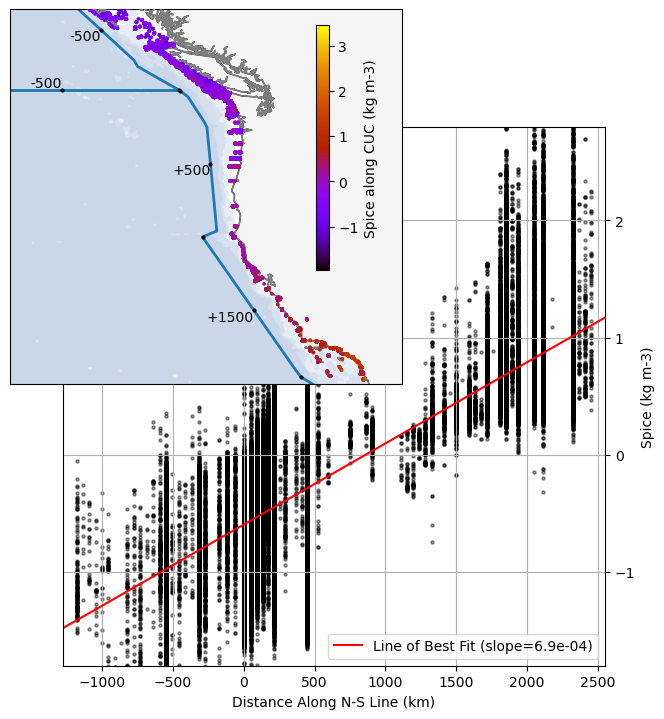

In [25]:
# Main axis
ylim = [32,53]
xlim = [-137,-115]

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 1, 1)

# Inset Cartopy axis as overlay (coordinates in figure fraction)
left, bottom, width, height = 0.05, 0.43, 0.7, 0.7  # Adjust as needed
ax0 = fig.add_axes([left, bottom, width, height], projection=crs.PlateCarree())

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# — 3) plot both legs —
ax0.plot(distline.lonNS, distline.latNS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(distline.lonEW, distline.latEW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-500, 2000 + 1, 500)
for t in ticks:
    # Draw tick on NS leg if in range
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if distline.distNS.min() <= t <= distline.distNS.max():
        idx = np.argmin(np.abs(distline.distNS - t))
        lon_t, lat_t = distline.lonNS[idx], distline.latNS[idx]
        ax0.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='top', ha='right', fontsize=10, zorder=6)

    if distline.distEW.min() <= t <= distline.distEW.max():
        idx = np.argmin(np.abs(distline.distEW - t))
        lon_t, lat_t = distline.lonEW[idx], distline.latEW[idx]
        ax0.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)
        
 # distline.distNS_out, distline.distEW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])
m, b = np.polyfit(obs_shelf.NSdist[~np.isnan(obs_shelf.spice)], obs_shelf.spice[~np.isnan(obs_shelf.spice)], 1)
xfit = np.arange(min(obs_shelf['NSdist'][~np.isnan(obs_shelf.spice)])-100, max(obs_shelf['NSdist'][~np.isnan(obs_shelf.spice)])+100)
yfit = m*xfit + b

sc = ax0.scatter(obs_shelf['longitude (degrees_east)'], obs_shelf['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_shelf['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, orientation='vertical', label='Spice along CUC (kg m-3)', shrink=0.5, aspect=20, anchor=(-1.8,0.7))


ax1.scatter(obs_shelf.NSdist, obs_shelf['spice'], s=5, alpha=0.4, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(obs_shelf.NSdist)-100, max(obs_shelf.NSdist)+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.set_ylim([-1.8, 2.8])
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend(loc='lower right')

